In [3]:
import sys
from typing import Iterable
import warnings

import nibabel
from neurolang import frontend as fe
import numpy as np
import pandas as pd
import nilearn.datasets
import nilearn.image
import nilearn.plotting


import xml.etree.ElementTree as ET
import json
from neurolang.frontend import NeurolangPDL, ExplicitVBR, ExplicitVBROverlay
from rdflib import RDFS
from sklearn.model_selection import KFold

from typing import Callable, Iterable

/Users/gzanitti/.local/lib/python3.8/site-packages/scikit_learn-0.23.2-py3.8-macosx-10.9-x86_64.egg/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.univariate_selection module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
iobc = nilearn.datasets.utils._fetch_files(
    nilearn.datasets.utils._get_dataset_dir('IOBC'),
    [
        (
            'iobc.xrdf',
            'http://data.bioontology.org/ontologies/IOBC/download?'
            'apikey=8b5b7825-538d-40e0-9e9e-5ab9274a9aeb&download_format=rdf',
            {'move': 'iobc.xrdf'}
        )
    ]
)[0]

In [5]:
nl = NeurolangPDL()
nl.load_ontology(iobc)

In [6]:
# NeuroSynth
mni_mask = nilearn.image.resample_img(
    nibabel.load(nilearn.datasets.fetch_icbm152_2009()["gm"]),
    np.eye(3) * 2
)

ns_database_fn, ns_features_fn = nilearn.datasets.utils._fetch_files(
    "neurolang",
    [
        (
            "database.txt",
            "https://github.com/neurosynth/neurosynth-data"
            "/raw/master/current_data.tar.gz",
            {"uncompress": True},
        ),
        (
            "features.txt",
            "https://github.com/neurosynth/neurosynth-data"
            "/raw/master/current_data.tar.gz",
            {"uncompress": True},
        ),
    ],
)

ns_database = pd.read_csv(ns_database_fn, sep="\t")
ns_database = ns_database[["x", "y", "z", "id"]]

ns_features = pd.read_csv(ns_features_fn, sep="\t")
ns_docs = ns_features[["pmid"]].drop_duplicates()
ns_terms = pd.melt(
    ns_features, var_name="term", id_vars="pmid", value_name="TfIdf"
).query("TfIdf > 1e-3")[["term", "pmid"]]

In [7]:
SelectedStudy = nl.add_uniform_probabilistic_choice_over_set(
    ns_docs, name="SelectedStudy"
)

In [8]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

ns_doc_folds = pd.concat(
    ns_docs.iloc[train].assign(fold=[i] * len(train))
    for i, (train, _) in enumerate(kfold.split(ns_docs))
)


StudyFolds = nl.add_tuple_set(ns_doc_folds, name='StudyFolds')

TermInStudy = nl.add_tuple_set(ns_terms, name="TermInStudy")
FocusReported = nl.add_tuple_set(ns_database, name="FocusReported")
Voxel = nl.add_tuple_set(
    nibabel.affines.apply_affine(
        mni_mask.affine,
        np.transpose(mni_mask.get_fdata().nonzero())
    ),
    name='Voxel'
)

label = nl.new_symbol(name=str(RDFS.label))
related = nl.new_symbol(name='http://www.w3.org/2004/02/skos/core#related')
altLabel = nl.new_symbol(name='http://www.w3.org/2004/02/skos/core#altLabel')
subclass_of = nl.new_symbol(name=str(RDFS.subClassOf))

In [9]:
@nl.add_symbol
def first_word(name: str) -> str:
    return name.split(" ")[0]

@nl.add_symbol
def mean(iterable: Iterable) -> float:
    return np.mean(iterable)


@nl.add_symbol
def std(iterable: Iterable) -> float:
    return np.std(iterable)

@nl.add_symbol
def agg_create_region_overlay_MNI(
    x: Iterable, y: Iterable, z: Iterable, p: Iterable
) -> ExplicitVBR:
    voxels = nibabel.affines.apply_affine(
        np.linalg.inv(mni_mask.affine),
        np.c_[x, y, z]
    )
    return ExplicitVBROverlay(
        voxels, mni_mask.affine, p, image_dim=mni_mask.shape
    )

nl.add_symbol(np.exp, name="exp", type_=Callable[[float], float])

exp: typing.Callable[[float], float] = <ufunc 'exp'>

## Synonyms

In [8]:
with nl.scope as e:
    e.RelatedBiostimulationTerm[e.word] = (e.word == 'pain')
    
    e.RelatedBiostimulationTerm[e.alternative_names] = (
        subclass_of(e.biostimulation_subclass, 'http://purl.jp/bio/4/id/200906066643737725') &
        label(e.pain_entity, 'Pain') & 
        related(e.pain_entity, e.biostimulation_subclass) &
        altLabel(e.biostimulation_subclass, e.alternative_names)
    )
    e.Synonym[e.short_name] = (
        (e.short_name == nl.symbols.first_word(e.alternative_names)) & 
        e.RelatedBiostimulationTerm(e.alternative_names)
    )
    
    e.FilteredBySynonym[e.t, e.s] = (
        e.TermInStudy[e.t, e.s] & e.Synonym[e.t]
    )
    
    (e.VoxelReported @ e.exp(-e.d / 5.0))[e.x1, e.y1, e.z1, e.s] = (
        e.FocusReported(e.x2, e.y2, e.z2, e.s)
        & e.Voxel(e.x1, e.y1, e.z1)
        & (e.d == e.EUCLIDEAN(e.x1, e.y1, e.z1, e.x2, e.y2, e.z2))
        & (e.d < 4)
    )
    
    e.Result[e.x, e.y, e.z, e.fold, e.PROB[e.x, e.y, e.z, e.fold]] = (
       (
           e.VoxelReported[e.x, e.y, e.z, e.s] 
       ) // (
           e.SelectedStudy[e.s] 
           & e.FilteredBySynonym[e.t, e.s] 
           & e.StudyFolds[e.s, e.fold]
       )  
    )
    
    e.ResultMean[e.x, e.y, e.z, e.mean(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]    
    )

    e.ResultStd[e.x, e.y, e.z, e.std(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]
    )

    e.ResultSummaryStats[
        e.x, e.y, e.z, e.prob_mean, e.prob_std
    ] = (
        e.ResultMean[e.x, e.y, e.z, e.prob_mean] &
        e.ResultStd[e.x, e.y, e.z, e.prob_std]
    )
    
    e.VoxelActivationImg[agg_create_region_overlay_MNI[e.x, e.y, e.z, e.p]] = (
        e.ResultMean(e.x, e.y, e.z, e.p)
    )
    
    res_syn = nl.solve_all()

/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are

In [9]:
res_syn['FilteredBySynonym'].as_pandas_dataframe().t.unique()

array(['nociceptive', 'noxious', 'pain'], dtype=object)

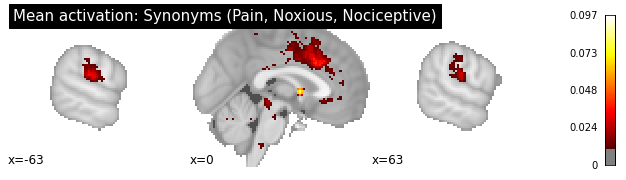

In [77]:
img_query = res_syn['VoxelActivationImg']

result_image = (
    img_query
    .fetch_one()
    [0]
    .spatial_image()
)
img = result_image.get_fdata()

plot = nilearn.plotting.plot_stat_map(
    result_image, threshold=np.percentile(img[img > 0], 95)
    ,display_mode='x',
    title='Mean activation: Synonyms (Pain, Noxious, Nociceptive)',
    cut_coords=np.linspace(-63, 63, 3),
)
nilearn.plotting.show()

In [11]:
with nl.scope as e:
    #e.RelatedBiostimulationTerm[e.word] = (e.word == 'pain')
    
    e.RelatedBiostimulationTerm[e.alternative_names] = (
        subclass_of(e.biostimulation_subclass, 'http://purl.jp/bio/4/id/200906066643737725') &
        label(e.pain_entity, 'Pain') & 
        related(e.pain_entity, e.biostimulation_subclass) &
        altLabel(e.biostimulation_subclass, e.alternative_names)
    )
    e.Synonym[e.short_name] = (
        (e.short_name == nl.symbols.first_word(e.alternative_names)) & 
        e.RelatedBiostimulationTerm(e.alternative_names)
    )
    
    e.FilteredBySynonym[e.t, e.s] = (
        e.TermInStudy[e.t, e.s] & e.Synonym[e.t]
    )
    
    (e.VoxelReported @ e.exp(-e.d / 5.0))[e.x1, e.y1, e.z1, e.s] = (
        e.FocusReported(e.x2, e.y2, e.z2, e.s)
        & e.Voxel(e.x1, e.y1, e.z1)
        & (e.d == e.EUCLIDEAN(e.x1, e.y1, e.z1, e.x2, e.y2, e.z2))
        & (e.d < 4)
    )
    
    e.Result[e.x, e.y, e.z, e.fold, e.PROB[e.x, e.y, e.z, e.fold]] = (
       (
           e.VoxelReported[e.x, e.y, e.z, e.s] 
       ) // (
           e.SelectedStudy[e.s] 
           & e.FilteredBySynonym[e.t, e.s] 
           & e.StudyFolds[e.s, e.fold]
       )  
    )
    
    e.ResultMean[e.x, e.y, e.z, e.mean(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]    
    )

    e.ResultStd[e.x, e.y, e.z, e.std(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]
    )

    e.ResultSummaryStats[
        e.x, e.y, e.z, e.prob_mean, e.prob_std
    ] = (
        e.ResultMean[e.x, e.y, e.z, e.prob_mean] &
        e.ResultStd[e.x, e.y, e.z, e.prob_std]
    )
    
    e.VoxelActivationImg[agg_create_region_overlay_MNI[e.x, e.y, e.z, e.p]] = (
        e.ResultMean(e.x, e.y, e.z, e.p)
    )
    
    res_syn_not_pain = nl.solve_all()

/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are

In [12]:
res_syn_not_pain['FilteredBySynonym'].as_pandas_dataframe().t.unique()

array(['nociceptive', 'noxious'], dtype=object)

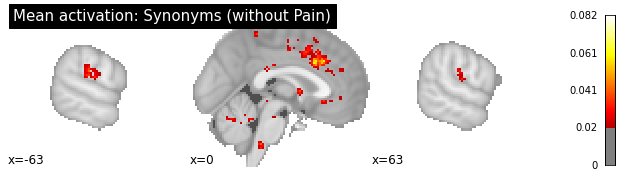

In [75]:
img_query = res_syn_not_pain['VoxelActivationImg']

result_image = (
    img_query
    .fetch_one()
    [0]
    .spatial_image()
)
img = result_image.get_fdata()

plot = nilearn.plotting.plot_stat_map(
    result_image, threshold=np.percentile(img[img > 0], 95)
    ,display_mode='x',
    title='Mean activation: Synonyms (without Pain)',
    cut_coords=np.linspace(-63, 63, 3),
)
nilearn.plotting.show()

## Single term

### Pain

In [14]:
with nl.scope as e:
    
    e.FilteredByTerm[e.t, e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'pain')
    )
    
    (e.VoxelReported @ e.exp(-e.d / 5.0))[e.x1, e.y1, e.z1, e.s] = (
        e.FocusReported(e.x2, e.y2, e.z2, e.s)
        & e.Voxel(e.x1, e.y1, e.z1)
        & (e.d == e.EUCLIDEAN(e.x1, e.y1, e.z1, e.x2, e.y2, e.z2))
        & (e.d < 4)
    )
    
    e.Result[e.x, e.y, e.z, e.fold, e.PROB[e.x, e.y, e.z, e.fold]] = (
       (
           e.VoxelReported[e.x, e.y, e.z, e.s] 
       ) // (
           e.SelectedStudy[e.s] 
           & e.FilteredByTerm[e.t, e.s] 
           & e.StudyFolds[e.s, e.fold]
       )  
    )
    
    e.ResultMean[e.x, e.y, e.z, e.mean(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]    
    )

    e.ResultStd[e.x, e.y, e.z, e.std(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]
    )

    e.ResultSummaryStats[
        e.x, e.y, e.z, e.prob_mean, e.prob_std
    ] = (
        e.ResultMean[e.x, e.y, e.z, e.prob_mean] &
        e.ResultStd[e.x, e.y, e.z, e.prob_std]
    )
    
    e.VoxelActivationImg[agg_create_region_overlay_MNI[e.x, e.y, e.z, e.p]] = (
        e.ResultMean(e.x, e.y, e.z, e.p)
    )
    
    
    res_pain = nl.solve_all()

/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are

In [15]:
res_pain['FilteredByTerm'].as_pandas_dataframe().t.unique()

array(['pain'], dtype=object)

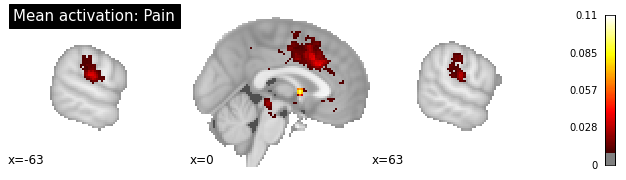

In [74]:
img_query = res_pain['VoxelActivationImg']

result_image = (
    img_query
    .fetch_one()
    [0]
    .spatial_image()
)
img = result_image.get_fdata()
plot = nilearn.plotting.plot_stat_map(
    result_image, threshold=np.percentile(img[img > 0], 95)
    ,display_mode='x',
    title='Mean activation: Pain',
    cut_coords=np.linspace(-63, 63, 3)
)
nilearn.plotting.show()

### Noxious

In [17]:
with nl.scope as e:
    
    e.FilteredByTerm[e.t, e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'noxious')
    )
    
    (e.VoxelReported @ e.exp(-e.d / 5.0))[e.x1, e.y1, e.z1, e.s] = (
        e.FocusReported(e.x2, e.y2, e.z2, e.s)
        & e.Voxel(e.x1, e.y1, e.z1)
        & (e.d == e.EUCLIDEAN(e.x1, e.y1, e.z1, e.x2, e.y2, e.z2))
        & (e.d < 4)
    )
    
    e.Result[e.x, e.y, e.z, e.fold, e.PROB[e.x, e.y, e.z, e.fold]] = (
       (
           e.VoxelReported[e.x, e.y, e.z, e.s] 
       ) // (
           e.SelectedStudy[e.s] 
           & e.FilteredByTerm[e.t, e.s] 
           & e.StudyFolds[e.s, e.fold]
       )  
    )
    
    e.ResultMean[e.x, e.y, e.z, e.mean(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]    
    )

    e.ResultStd[e.x, e.y, e.z, e.std(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]
    )

    e.ResultSummaryStats[
        e.x, e.y, e.z, e.prob_mean, e.prob_std
    ] = (
        e.ResultMean[e.x, e.y, e.z, e.prob_mean] &
        e.ResultStd[e.x, e.y, e.z, e.prob_std]
    )
    
    e.VoxelActivationImg[agg_create_region_overlay_MNI[e.x, e.y, e.z, e.p]] = (
        e.ResultMean(e.x, e.y, e.z, e.p)
    )
    
    
    res_nox = nl.solve_all()

/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are

In [18]:
res_nox['FilteredByTerm'].as_pandas_dataframe().t.unique()

array(['noxious'], dtype=object)

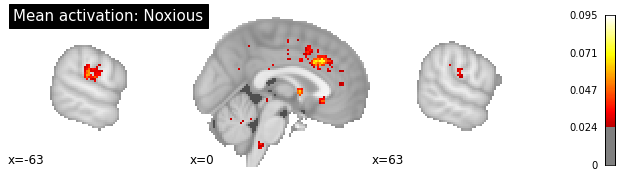

In [73]:
img_query = res_nox['VoxelActivationImg']

result_image = (
    img_query
    .fetch_one()
    [0]
    .spatial_image()
)
img = result_image.get_fdata()
plot = nilearn.plotting.plot_stat_map(
    result_image, threshold=np.percentile(img[img > 0], 95)
    ,display_mode='x',
    title='Mean activation: Noxious',
    cut_coords=np.linspace(-63, 63, 3)
)
nilearn.plotting.show()

### Nociceptive

In [20]:
with nl.scope as e:
    
    e.FilteredByTerm[e.t, e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'nociceptive')
    )
    
    (e.VoxelReported @ e.exp(-e.d / 5.0))[e.x1, e.y1, e.z1, e.s] = (
        e.FocusReported(e.x2, e.y2, e.z2, e.s)
        & e.Voxel(e.x1, e.y1, e.z1)
        & (e.d == e.EUCLIDEAN(e.x1, e.y1, e.z1, e.x2, e.y2, e.z2))
        & (e.d < 4)
    )
    
    e.Result[e.x, e.y, e.z, e.fold, e.PROB[e.x, e.y, e.z, e.fold]] = (
       (
           e.VoxelReported[e.x, e.y, e.z, e.s] 
       ) // (
           e.SelectedStudy[e.s] 
           & e.FilteredByTerm[e.t, e.s] 
           & e.StudyFolds[e.s, e.fold]
       )  
    )
    
    e.ResultMean[e.x, e.y, e.z, e.mean(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]    
    )

    e.ResultStd[e.x, e.y, e.z, e.std(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]
    )

    e.ResultSummaryStats[
        e.x, e.y, e.z, e.prob_mean, e.prob_std
    ] = (
        e.ResultMean[e.x, e.y, e.z, e.prob_mean] &
        e.ResultStd[e.x, e.y, e.z, e.prob_std]
    )
    
    e.VoxelActivationImg[agg_create_region_overlay_MNI[e.x, e.y, e.z, e.p]] = (
        e.ResultMean(e.x, e.y, e.z, e.p)
    )
    
    
    res_noc = nl.solve_all()

/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are

In [21]:
res_noc['FilteredByTerm'].as_pandas_dataframe().t.unique()

array(['nociceptive'], dtype=object)

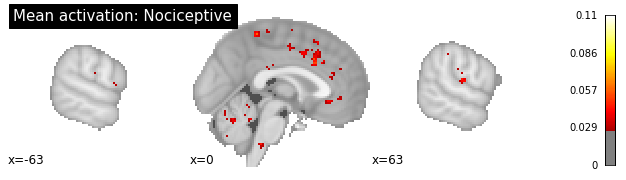

In [72]:
img_query = res_noc['VoxelActivationImg']

result_image = (
    img_query
    .fetch_one()
    [0]
    .spatial_image()
)
img = result_image.get_fdata()
plot = nilearn.plotting.plot_stat_map(
    result_image, threshold=np.percentile(img[img > 0], 95)
    ,display_mode='x',
    title='Mean activation: Nociceptive',
    cut_coords=np.linspace(-63, 63, 3)
)
nilearn.plotting.show()

## Segregation

### Pain

In [23]:
with nl.scope as e:
    
    e.FilteredPain[e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'pain')
    )
    
    e.FilteredNoxious[e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'noxious')
    )
    
    e.FilteredNociceptive[e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'nociceptive')
    )
    
    e.FilteredByTerm['pain', e.s] = (
        e.FilteredPain[e.s] &
        ~(e.FilteredNoxious[e.s]) &
        ~(e.FilteredNociceptive[e.s])
    )
    
    (e.VoxelReported @ e.exp(-e.d / 5.0))[e.x1, e.y1, e.z1, e.s] = (
        e.FocusReported(e.x2, e.y2, e.z2, e.s)
        & e.Voxel(e.x1, e.y1, e.z1)
        & (e.d == e.EUCLIDEAN(e.x1, e.y1, e.z1, e.x2, e.y2, e.z2))
        & (e.d < 4)
    )
    
    e.Result[e.x, e.y, e.z, e.fold, e.PROB[e.x, e.y, e.z, e.fold]] = (
       (
           e.VoxelReported[e.x, e.y, e.z, e.s] 
       ) // (
           e.SelectedStudy[e.s] 
           & e.FilteredByTerm[e.t, e.s] 
           & e.StudyFolds[e.s, e.fold]
       )  
    )
    
    e.ResultMean[e.x, e.y, e.z, e.mean(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]    
    )

    e.ResultStd[e.x, e.y, e.z, e.std(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]
    )

    e.ResultSummaryStats[
        e.x, e.y, e.z, e.prob_mean, e.prob_std
    ] = (
        e.ResultMean[e.x, e.y, e.z, e.prob_mean] &
        e.ResultStd[e.x, e.y, e.z, e.prob_std]
    )
    
    e.VoxelActivationImg[agg_create_region_overlay_MNI[e.x, e.y, e.z, e.p]] = (
        e.ResultMean(e.x, e.y, e.z, e.p)
    )
    
    
    res_seg_pain = nl.solve_all()

/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
img_query = res_seg_pain['VoxelActivationImg']

result_image = (
    img_query
    .fetch_one()
    [0]
    .spatial_image()
)
img = result_image.get_fdata()
plot = nilearn.plotting.plot_stat_map(
    result_image, threshold=np.percentile(img[img > 0], 90)
    ,display_mode='x',
    cut_coords=np.linspace(-63, 63, 5)
)
nilearn.plotting.show()

### Noxious

In [ ]:
with nl.scope as e:
    
    e.FilteredPain[e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'pain')
    )
    
    e.FilteredNoxious[e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'noxious')
    )
    
    e.FilteredNociceptive[e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'nociceptive')
    )
    
    e.FilteredByTerm['noxious', e.s] = (
        e.FilteredNoxious[e.s] &
        ~(e.FilteredPain[e.s]) &
        ~(e.FilteredNociceptive[e.s])
    )
    
    (e.VoxelReported @ e.exp(-e.d / 5.0))[e.x1, e.y1, e.z1, e.s] = (
        e.FocusReported(e.x2, e.y2, e.z2, e.s)
        & e.Voxel(e.x1, e.y1, e.z1)
        & (e.d == e.EUCLIDEAN(e.x1, e.y1, e.z1, e.x2, e.y2, e.z2))
        & (e.d < 4)
    )
    
    e.Result[e.x, e.y, e.z, e.fold, e.PROB[e.x, e.y, e.z, e.fold]] = (
       (
           e.VoxelReported[e.x, e.y, e.z, e.s] 
       ) // (
           e.SelectedStudy[e.s] 
           & e.FilteredByTerm[e.t, e.s] 
           & e.StudyFolds[e.s, e.fold]
       )  
    )
    
    e.ResultMean[e.x, e.y, e.z, e.mean(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]    
    )

    e.ResultStd[e.x, e.y, e.z, e.std(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]
    )

    e.ResultSummaryStats[
        e.x, e.y, e.z, e.prob_mean, e.prob_std
    ] = (
        e.ResultMean[e.x, e.y, e.z, e.prob_mean] &
        e.ResultStd[e.x, e.y, e.z, e.prob_std]
    )
    
    e.VoxelActivationImg[agg_create_region_overlay_MNI[e.x, e.y, e.z, e.p]] = (
        e.ResultMean(e.x, e.y, e.z, e.p)
    )
    
    
    res_seg_nox = nl.solve_all()

In [ ]:
img_query = res_seg_nox['VoxelActivationImg']

result_image = (
    img_query
    .fetch_one()
    [0]
    .spatial_image()
)
img = result_image.get_fdata()
plot = nilearn.plotting.plot_stat_map(
    result_image, threshold=np.percentile(img[img > 0], 95)
    ,display_mode='x',
    cut_coords=np.linspace(-63, 63, 5)
)
nilearn.plotting.show()

### Nociceptive

In [ ]:
with nl.scope as e:
    
    e.FilteredPain[e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'pain')
    )
    
    e.FilteredNoxious[e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'noxious')
    )
    
    e.FilteredNociceptive[e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'nociceptive')
    )
    
    e.FilteredByTerm['nociceptive', e.s] = (
        e.FilteredNociceptive[e.s] &
        ~(e.FilteredPain[e.s]) &
        ~(e.FilteredNoxious[e.s])
    )
    
    (e.VoxelReported @ e.exp(-e.d / 5.0))[e.x1, e.y1, e.z1, e.s] = (
        e.FocusReported(e.x2, e.y2, e.z2, e.s)
        & e.Voxel(e.x1, e.y1, e.z1)
        & (e.d == e.EUCLIDEAN(e.x1, e.y1, e.z1, e.x2, e.y2, e.z2))
        & (e.d < 4)
    )
    
    e.Result[e.x, e.y, e.z, e.fold, e.PROB[e.x, e.y, e.z, e.fold]] = (
       (
           e.VoxelReported[e.x, e.y, e.z, e.s] 
       ) // (
           e.SelectedStudy[e.s] 
           & e.FilteredByTerm[e.t, e.s] 
           & e.StudyFolds[e.s, e.fold]
       )  
    )
    
    e.ResultMean[e.x, e.y, e.z, e.mean(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]    
    )

    e.ResultStd[e.x, e.y, e.z, e.std(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]
    )

    e.ResultSummaryStats[
        e.x, e.y, e.z, e.prob_mean, e.prob_std
    ] = (
        e.ResultMean[e.x, e.y, e.z, e.prob_mean] &
        e.ResultStd[e.x, e.y, e.z, e.prob_std]
    )
    
    e.VoxelActivationImg[agg_create_region_overlay_MNI[e.x, e.y, e.z, e.p]] = (
        e.ResultMean(e.x, e.y, e.z, e.p)
    )
    
    
    res_seg_noc = nl.solve_all()

In [ ]:
img_query = res_seg_noc['VoxelActivationImg']

result_image = (
    img_query
    .fetch_one()
    [0]
    .spatial_image()
)
img = result_image.get_fdata()
plot = nilearn.plotting.plot_stat_map(
    result_image, threshold=np.percentile(img[img > 0], 95)
    ,display_mode='x',
    cut_coords=np.linspace(-63, 63, 5)
)
nilearn.plotting.show()

## Random test

### Pain - Noxious

In [ ]:
with nl.scope as e:
    
    e.FilteredByTerm[e.t, e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'pain')
    )
    
    e.FilteredByTerm[e.t, e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'noxious')
    )
    
    (e.VoxelReported @ e.exp(-e.d / 5.0))[e.x1, e.y1, e.z1, e.s] = (
        e.FocusReported(e.x2, e.y2, e.z2, e.s)
        & e.Voxel(e.x1, e.y1, e.z1)
        & (e.d == e.EUCLIDEAN(e.x1, e.y1, e.z1, e.x2, e.y2, e.z2))
        & (e.d < 4)
    )
    
    e.Result[e.x, e.y, e.z, e.fold, e.PROB[e.x, e.y, e.z, e.fold]] = (
       (
           e.VoxelReported[e.x, e.y, e.z, e.s] 
       ) // (
           e.SelectedStudy[e.s] 
           & e.FilteredByTerm[e.t, e.s] 
           & e.StudyFolds[e.s, e.fold]
       )  
    )
    
    e.ResultMean[e.x, e.y, e.z, e.mean(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]    
    )

    e.ResultStd[e.x, e.y, e.z, e.std(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]
    )

    e.ResultSummaryStats[
        e.x, e.y, e.z, e.prob_mean, e.prob_std
    ] = (
        e.ResultMean[e.x, e.y, e.z, e.prob_mean] &
        e.ResultStd[e.x, e.y, e.z, e.prob_std]
    )
    
    e.VoxelActivationImg[agg_create_region_overlay_MNI[e.x, e.y, e.z, e.p]] = (
        e.ResultMean(e.x, e.y, e.z, e.p)
    )
    
    
    res_pnox = nl.solve_all()

In [ ]:
img_query = res_pnox['VoxelActivationImg']

result_image = (
    img_query
    .fetch_one()
    [0]
    .spatial_image()
)
img = result_image.get_fdata()
plot = nilearn.plotting.plot_stat_map(
    result_image, threshold=np.percentile(img[img > 0], 95)
    ,display_mode='x',
    cut_coords=np.linspace(-63, 63, 5)
)
nilearn.plotting.show()

### Pain - Nociceptive

In [ ]:
with nl.scope as e:
    
    e.FilteredByTerm[e.t, e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'pain')
    )
    
    e.FilteredByTerm[e.t, e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'nociceptive')
    )
    
    (e.VoxelReported @ e.exp(-e.d / 5.0))[e.x1, e.y1, e.z1, e.s] = (
        e.FocusReported(e.x2, e.y2, e.z2, e.s)
        & e.Voxel(e.x1, e.y1, e.z1)
        & (e.d == e.EUCLIDEAN(e.x1, e.y1, e.z1, e.x2, e.y2, e.z2))
        & (e.d < 4)
    )
    
    e.Result[e.x, e.y, e.z, e.fold, e.PROB[e.x, e.y, e.z, e.fold]] = (
       (
           e.VoxelReported[e.x, e.y, e.z, e.s] 
       ) // (
           e.SelectedStudy[e.s] 
           & e.FilteredByTerm[e.t, e.s] 
           & e.StudyFolds[e.s, e.fold]
       )  
    )
    
    e.ResultMean[e.x, e.y, e.z, e.mean(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]    
    )

    e.ResultStd[e.x, e.y, e.z, e.std(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]
    )

    e.ResultSummaryStats[
        e.x, e.y, e.z, e.prob_mean, e.prob_std
    ] = (
        e.ResultMean[e.x, e.y, e.z, e.prob_mean] &
        e.ResultStd[e.x, e.y, e.z, e.prob_std]
    )
    
    e.VoxelActivationImg[agg_create_region_overlay_MNI[e.x, e.y, e.z, e.p]] = (
        e.ResultMean(e.x, e.y, e.z, e.p)
    )
    
    
    res_pnoc = nl.solve_all()

In [ ]:
img_query = res_pnoc['VoxelActivationImg']

result_image = (
    img_query
    .fetch_one()
    [0]
    .spatial_image()
)
img = result_image.get_fdata()
plot = nilearn.plotting.plot_stat_map(
    result_image, threshold=np.percentile(img[img > 0], 95)
    ,display_mode='x',
    cut_coords=np.linspace(-63, 63, 5)
)
nilearn.plotting.show()

### Noxious - Nociceptive

In [ ]:
with nl.scope as e:
    
    e.FilteredByTerm[e.t, e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'noxious')
    )
    
    e.FilteredByTerm[e.t, e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'nociceptive')
    )
    
    (e.VoxelReported @ e.exp(-e.d / 5.0))[e.x1, e.y1, e.z1, e.s] = (
        e.FocusReported(e.x2, e.y2, e.z2, e.s)
        & e.Voxel(e.x1, e.y1, e.z1)
        & (e.d == e.EUCLIDEAN(e.x1, e.y1, e.z1, e.x2, e.y2, e.z2))
        & (e.d < 4)
    )
    
    e.Result[e.x, e.y, e.z, e.fold, e.PROB[e.x, e.y, e.z, e.fold]] = (
       (
           e.VoxelReported[e.x, e.y, e.z, e.s] 
       ) // (
           e.SelectedStudy[e.s] 
           & e.FilteredByTerm[e.t, e.s] 
           & e.StudyFolds[e.s, e.fold]
       )  
    )
    
    e.ResultMean[e.x, e.y, e.z, e.mean(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]    
    )

    e.ResultStd[e.x, e.y, e.z, e.std(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]
    )

    e.ResultSummaryStats[
        e.x, e.y, e.z, e.prob_mean, e.prob_std
    ] = (
        e.ResultMean[e.x, e.y, e.z, e.prob_mean] &
        e.ResultStd[e.x, e.y, e.z, e.prob_std]
    )
    
    e.VoxelActivationImg[agg_create_region_overlay_MNI[e.x, e.y, e.z, e.p]] = (
        e.ResultMean(e.x, e.y, e.z, e.p)
    )
    
    
    res_noc_nox = nl.solve_all()

In [ ]:
img_query = res_noc_nox['VoxelActivationImg']

result_image = (
    img_query
    .fetch_one()
    [0]
    .spatial_image()
)
img = result_image.get_fdata()
plot = nilearn.plotting.plot_stat_map(
    result_image, threshold=np.percentile(img[img > 0], 95)
    ,display_mode='x',
    cut_coords=np.linspace(-63, 63, 5)
)
nilearn.plotting.show()

## Results

In [24]:
def create_region(x, y, z, it):
    voxels = nibabel.affines.apply_affine(
        np.linalg.inv(mni_mask.affine),
        np.c_[x, y, z]
    )
    return fe.ExplicitVBR(voxels, it.affine, image_dim=it.shape)

In [78]:
thr_val = 95

summary_syn = res_syn['ResultSummaryStats'].as_pandas_dataframe()
thr = np.percentile(summary_syn.prob_mean[summary_syn.prob_mean > 0], thr_val)
summary_syn = summary_syn[summary_syn.prob_mean > thr].set_index(['x', 'y', 'z'])

summary_syn_not_pain = res_syn_not_pain['ResultSummaryStats'].as_pandas_dataframe()
thr = np.percentile(summary_syn_not_pain.prob_mean[summary_syn_not_pain.prob_mean > 0], thr_val)
summary_syn_not_pain = summary_syn_not_pain[summary_syn_not_pain.prob_mean > thr].set_index(['x', 'y', 'z'])

summary_pain = res_pain['ResultSummaryStats'].as_pandas_dataframe()
thr = np.percentile(summary_pain.prob_mean[summary_pain.prob_mean > 0], thr_val)
summary_pain = summary_pain[summary_pain.prob_mean > thr].set_index(['x', 'y', 'z'])

summary_nox = res_nox['ResultSummaryStats'].as_pandas_dataframe()
thr = np.percentile(summary_nox.prob_mean[summary_nox.prob_mean > 0], thr_val)
summary_nox = summary_nox[summary_nox.prob_mean > thr].set_index(['x', 'y', 'z'])

summary_noc = res_noc['ResultSummaryStats'].as_pandas_dataframe()
thr = np.percentile(summary_noc.prob_mean[summary_noc.prob_mean > 0], thr_val)
summary_noc = summary_noc[summary_noc.prob_mean > thr].set_index(['x', 'y', 'z'])

#summary_seg_pain = res_seg_pain['ResultSummaryStats'].as_pandas_dataframe()
#thr = np.percentile(summary_seg_pain.prob_mean[summary_seg_pain.prob_mean > 0], thr_val)
#summary_seg_pain = summary_seg_pain[summary_seg_pain.prob_mean > thr].set_index(['x', 'y', 'z'])

#summary_seg_nox = res_seg_nox['ResultSummaryStats'].as_pandas_dataframe()
#thr = np.percentile(summary_seg_nox.prob_mean[summary_seg_nox.prob_mean > 0], thr_val)
#summary_seg_nox = summary_seg_nox[summary_seg_nox.prob_mean > thr].set_index(['x', 'y', 'z'])

#summary_seg_noc = res_seg_noc['ResultSummaryStats'].as_pandas_dataframe()
#thr = np.percentile(summary_seg_noc.prob_mean[summary_seg_noc.prob_mean > 0], thr_val)
#summary_seg_noc = summary_seg_noc[summary_seg_noc.prob_mean > thr].set_index(['x', 'y', 'z'])




#summary_pnox = res_pnox['ResultSummaryStats'].as_pandas_dataframe()
#thr = np.percentile(summary_pnox.prob_mean[summary_pnox.prob_mean > 0], thr_val)
#summary_pnox = summary_pnox[summary_pnox.prob_mean > thr].set_index(['x', 'y', 'z'])

#summary_pnoc = res_pnoc['ResultSummaryStats'].as_pandas_dataframe()
#thr = np.percentile(summary_pnoc.prob_mean[summary_pnoc.prob_mean > 0], thr_val)
#summary_pnoc = summary_pnoc[summary_pnoc.prob_mean > thr].set_index(['x', 'y', 'z'])

#summary_noc_nox = res_noc_nox['ResultSummaryStats'].as_pandas_dataframe()
#thr = np.percentile(summary_noc_nox.prob_mean[summary_noc_nox.prob_mean > 0], thr_val)
#summary_noc_nox = summary_noc_nox[summary_noc_nox.prob_mean > thr].set_index(['x', 'y', 'z'])

suf = {
    'Synonyms (Pain, Noxious, Nociceptive)': summary_syn,
    'Synonyms (without Pain)': summary_syn_not_pain,
    'Pain': summary_pain,
    'Noxious': summary_nox,
    'Nociceptive': summary_noc,
    #'seg_pain': summary_seg_pain,
    #'seg_nox': summary_seg_nox,
    #'seg_noc': summary_seg_noc,
    #'pain_nox': summary_pnox,
    #'pain_noc': summary_pnoc,
    #'noc_nox': summary_noc_nox,
}



In [66]:
a = 'Synonyms'
b = 'Pain'
#if a != 'Synonyms':
#    continue
df = suf[a].join(suf[b], lsuffix=f'_{a}', rsuffix=f'_{b}')
l = f'prob_std_{a}'
r = f'prob_std_{b}'
df['res_std'] =  df[l] - df[r]

<AxesSubplot:>

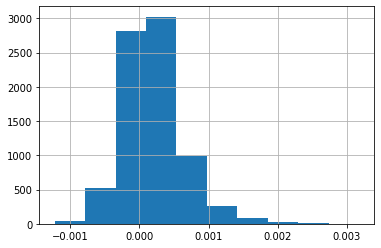

In [67]:
df['res_std'].hist()

std Synonyms (Pain, Noxious, Nociceptive) < Synonyms (without Pain): 4502, std Synonyms (Pain, Noxious, Nociceptive) > Synonyms (without Pain): 42, eq: 0 :)
min/max: -0.011835009433411854 0.005396206452957992



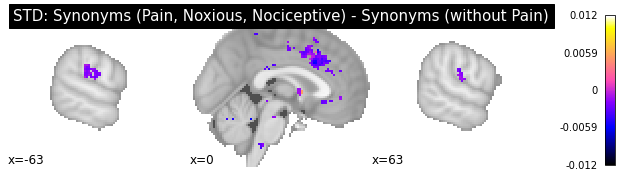

std Synonyms (Pain, Noxious, Nociceptive) < Pain: 2550, std Synonyms (Pain, Noxious, Nociceptive) > Pain: 5230, eq: 0 
min/max: -0.0012243308331105155 0.0031747770866914203



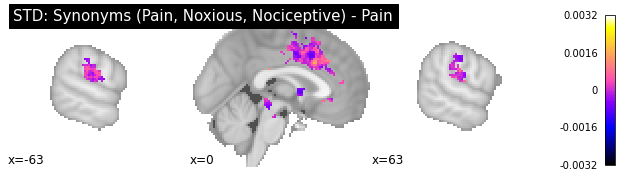

std Synonyms (Pain, Noxious, Nociceptive) < Noxious: 3540, std Synonyms (Pain, Noxious, Nociceptive) > Noxious: 58, eq: 0 :)
min/max: -0.013193553010851242 0.004628482918720905



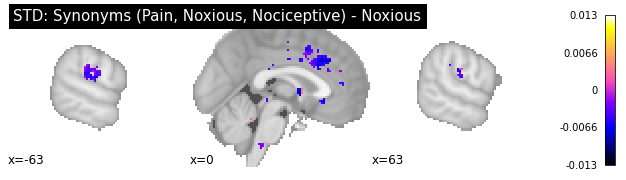

std Synonyms (Pain, Noxious, Nociceptive) < Nociceptive: 2412, std Synonyms (Pain, Noxious, Nociceptive) > Nociceptive: 77, eq: 0 :)
min/max: -0.014879742686555586 0.0033161646397372405



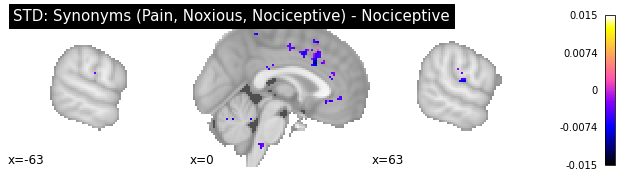

std Synonyms (without Pain) < Pain: 43, std Synonyms (without Pain) > Pain: 3559, eq: 0 
min/max: -0.006118058787061586 0.014746975318640852



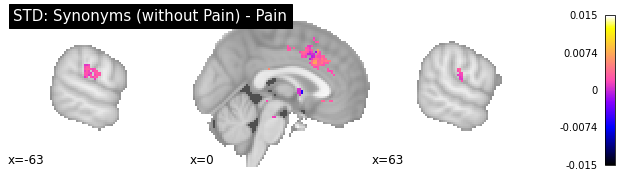

std Synonyms (without Pain) < Noxious: 2656, std Synonyms (without Pain) > Noxious: 669, eq: 0 :)
min/max: -0.008526730920049443 0.010231386331986548



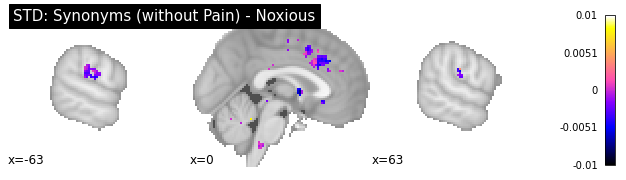

std Synonyms (without Pain) < Nociceptive: 2182, std Synonyms (without Pain) > Nociceptive: 236, eq: 0 :)
min/max: -0.007675591967491016 0.011525635663221009



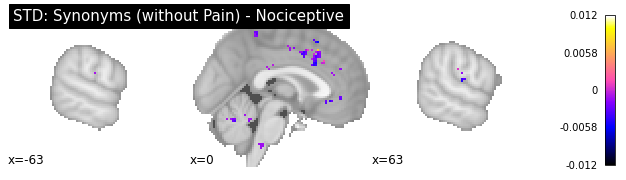

std Pain < Noxious: 2917, std Pain > Noxious: 44, eq: 0 :)
min/max: -0.014499661584573473 0.005350335252824499



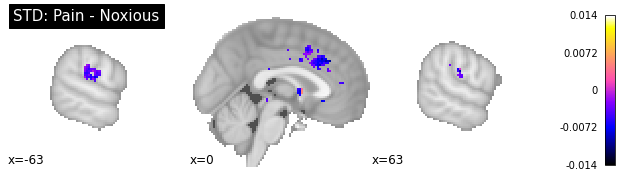

std Pain < Nociceptive: 1954, std Pain > Nociceptive: 55, eq: 0 :)
min/max: -0.017961821778207192 0.0019944279967826876



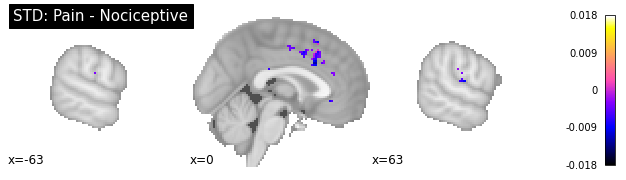

std Noxious < Nociceptive: 888, std Noxious > Nociceptive: 436, eq: 0 :)
min/max: -0.011852170861009828 0.011689126978361846



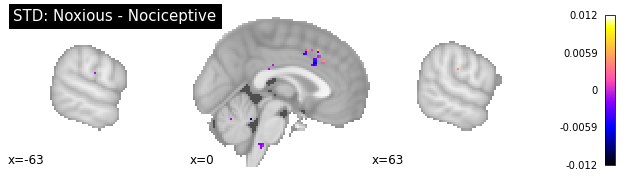

In [79]:
import itertools
from neurolang.regions import region_union

comb = itertools.combinations(suf, 2)

'''img_query = res_syn['VoxelActivationImg']

result_image = (
    img_query
    .fetch_one()
    [0]
    .spatial_image()
)
img = result_image.get_fdata()

plot = nilearn.plotting.plot_stat_map(
    result_image, threshold=np.percentile(img[img > 0], 95)
    ,display_mode='x',
    cut_coords=np.linspace(-63, 63, 5),
)
nilearn.plotting.show()

img_query = res_pain['VoxelActivationImg']

result_image = (
    img_query
    .fetch_one()
    [0]
    .spatial_image()
)
img = result_image.get_fdata()
plot = nilearn.plotting.plot_stat_map(
    result_image, threshold=np.percentile(img[img > 0], 95)
    ,display_mode='x',
    cut_coords=np.linspace(-63, 63, 5)
)
nilearn.plotting.show()'''

for a, b in comb:
    #if a != 'Synonyms':
    #    continue
    df = suf[a].join(suf[b], lsuffix=f'_{a}', rsuffix=f'_{b}')
    l = f'prob_std_{a}'
    r = f'prob_std_{b}'
    df['res_std'] =  df[l] - df[r]

    m = len(df[df["res_std"] < 0])
    p = len(df[df["res_std"] > 0])
    e = len(df[df["res_std"] == 0])
    
    print(f'std {a} < {b}: {m}, std {a} > {b}: {p}, eq: {e}', ':)' if p < m else '')
    #print(f'{df[l].mean() - df[r].mean()}')
    #print(f'{df["res_std"].mean()}')
    print(f'min/max: {df["res_std"].min()}', df['res_std'].max())
    print()
    
    df = df.reset_index()
    temp = df[['x', 'y', 'z', 'res_std']]

    regions = []
    vox_prob = []
    for x, y, z, p in temp.values:
        r_overlay = create_region(x, y, z, mni_mask)
        vox_prob.append((r_overlay.voxels, p))
        regions.append(r_overlay)

    regions = region_union(regions)

    prob_img_nl = nibabel.spatialimages.SpatialImage(
        np.zeros(regions.image_dim, dtype=float), affine=mni_mask.affine
    )
    for v, p in vox_prob:
        prob_img_nl.dataobj[tuple(v.T)] = p
        
    nilearn.plotting.plot_stat_map(
        prob_img_nl, 
        title=f'STD: {a} - {b}', 
        display_mode='x',
        cmap='gnuplot2',
        cut_coords=np.linspace(-63, 63, 3),
    )
    nilearn.plotting.show()

In [57]:
thr_val = 95

result_syn = res_syn['Result'].as_pandas_dataframe()
thr = np.percentile(result_syn.PROB[result_syn.PROB > 0], thr_val)
result_syn = result_syn[result_syn.PROB > thr].set_index(['x', 'y', 'z'])
#result_syn = result_syn.set_index(['x', 'y', 'z'])

result_syn_not_pain = res_syn_not_pain['Result'].as_pandas_dataframe()
thr = np.percentile(result_syn_not_pain.PROB[result_syn_not_pain.PROB > 0], thr_val)
result_syn_not_pain = result_syn_not_pain[result_syn_not_pain.PROB > thr].set_index(['x', 'y', 'z'])
#result_syn_not_pain = result_syn_not_pain.set_index(['x', 'y', 'z'])

result_pain = res_pain['Result'].as_pandas_dataframe()
thr = np.percentile(result_pain.PROB[result_pain.PROB > 0], thr_val)
result_pain = result_pain[result_pain.PROB > thr].set_index(['x', 'y', 'z'])
#result_pain = result_pain.set_index(['x', 'y', 'z'])

result_nox = res_nox['Result'].as_pandas_dataframe()
thr = np.percentile(result_nox.PROB[result_nox.PROB > 0], thr_val)
result_nox = result_nox[result_nox.PROB > thr].set_index(['x', 'y', 'z'])
#result_nox = result_nox.set_index(['x', 'y', 'z'])

result_noc = res_noc['Result'].as_pandas_dataframe()
thr = np.percentile(result_noc.PROB[result_noc.PROB > 0], thr_val)
result_noc = result_noc[result_noc.PROB > thr].set_index(['x', 'y', 'z'])
#result_noc = result_noc.set_index(['x', 'y', 'z'])

suf = {
    'Synonyms': result_syn,
    'Synonyms (without Pain)': result_syn_not_pain,
    'Pain': result_pain,
    'Noxious': result_nox,
    'Nociceptive': result_noc,
}

/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
<ipython-input-63-22ea559be684>:53: RuntimeWarning: divide by zero encountered in log
  p_img.dataobj[tuple(v.T)] = 1-np.log(cp)


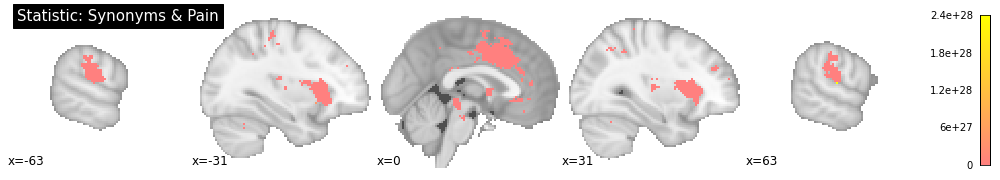

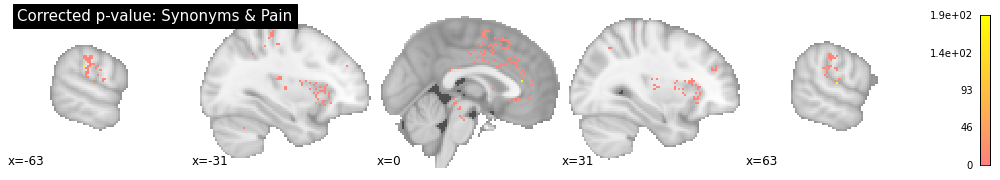

/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
<ipython-input-63-22ea559be684>:53: RuntimeWarning: divide by zero encountered in log
  p_img.dataobj[tuple(v.T)] = 1-np.log(cp)


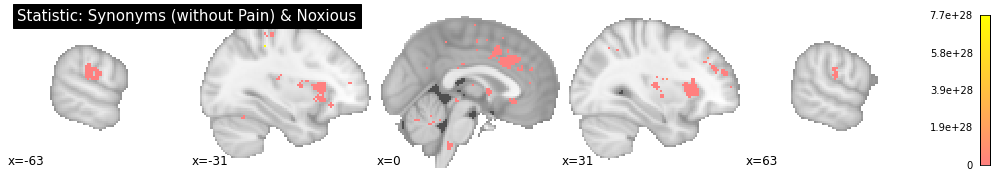

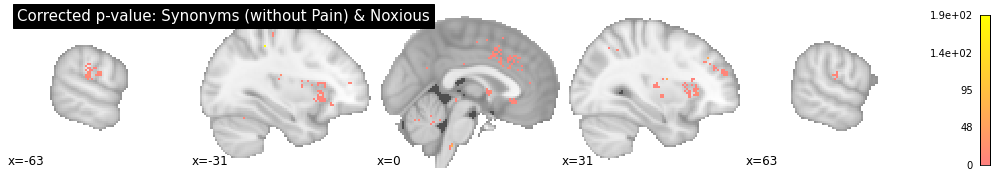

/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
<ipython-input-63-22ea559be684>:53: RuntimeWarning: divide by zero encountered in log
  p_img.dataobj[tuple(v.T)] = 1-np.log(cp)


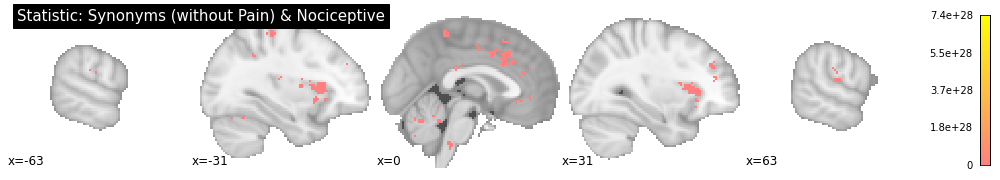

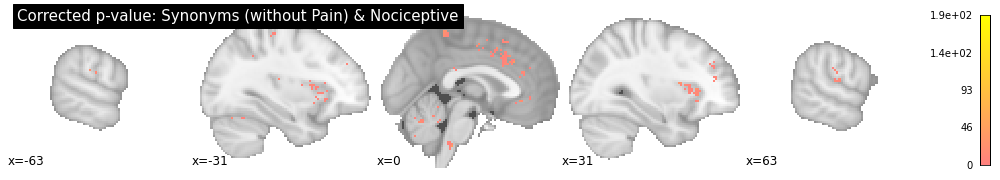

/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
<ipython-input-63-22ea559be684>:53: RuntimeWarning: divide by zero encountered in log
  p_img.dataobj[tuple(v.T)] = 1-np.log(cp)


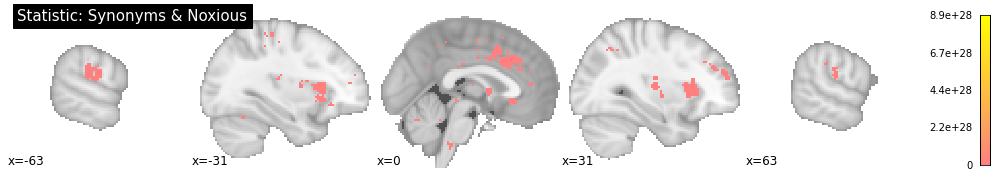

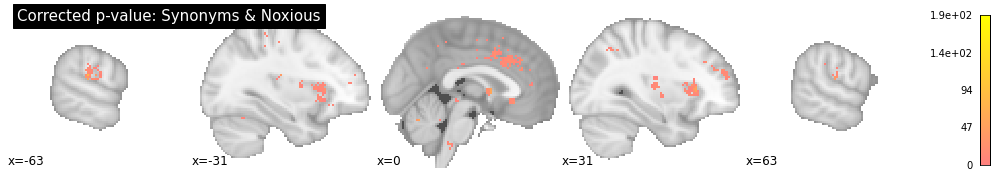

/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
<ipython-input-63-22ea559be684>:53: RuntimeWarning: divide by zero encountered in log
  p_img.dataobj[tuple(v.T)] = 1-np.log(cp)


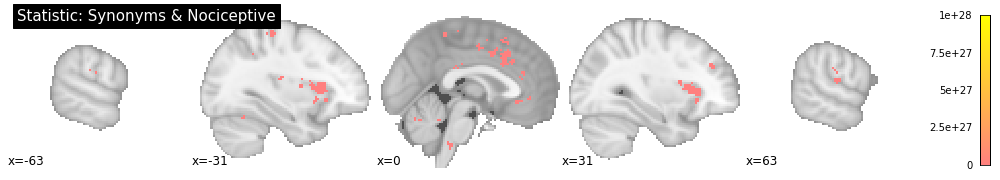

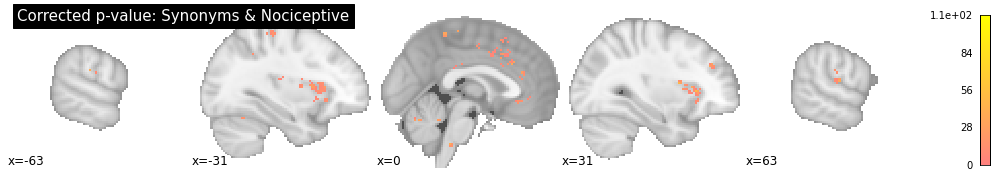

In [63]:
import itertools
from neurolang.regions import region_union
from statsmodels.stats.multitest import multipletests
import scipy

comb = [('Synonyms', 'Pain'), 
        ('Synonyms (without Pain)', 'Noxious'), 
        ('Synonyms (without Pain)', 'Nociceptive'),
        ('Synonyms', 'Noxious'), 
        ('Synonyms', 'Nociceptive')
       ]

for a, b in comb:
    df = suf[a].join(suf[b], lsuffix=f'_{a}', rsuffix=f'_{b}')
    df = df.dropna(axis=0)
    df = df.reset_index()
    
    gp = df.groupby(['x', 'y', 'z'])
    
    res = []
    for g in gp:
        s = g[1][f'PROB_{a}'].values 
        w = g[1][f'PROB_{b}'].values
        l = scipy.stats.levene(s, w)
        res.append((g[0], l[0], l[1]))
        
    df2 = pd.DataFrame(res, columns=['voxel', 'statistic', 'pvalue'])
    df2 = df2.dropna(axis=0)
    
    mtest = multipletests([p.pvalue for p in df2.itertuples()], method='fdr_bh')
    df2['corrected_pvalue'] = mtest[1]
    
    regions = []
    vox_prob = []
    for v, s, p, cp in df2.values:
        x, y, z = v
        r_overlay = create_region(x, y, z, mni_mask)
        vox_prob.append((r_overlay.voxels, s, cp))
        regions.append(r_overlay)

    regions = region_union(regions)

    p_img = nibabel.spatialimages.SpatialImage(
        np.zeros(regions.image_dim, dtype=float), affine=mni_mask.affine
    )

    s_img = nibabel.spatialimages.SpatialImage(
        np.zeros(regions.image_dim, dtype=float), affine=mni_mask.affine
    )
    for v, s, cp in vox_prob:
        s_img.dataobj[tuple(v.T)] = s
        if cp < 0.05:
            p_img.dataobj[tuple(v.T)] = 1-np.log(cp)


    nilearn.plotting.plot_stat_map(
        s_img, 
        title=f'Statistic: {a} & {b}', 
        display_mode='x',
        cmap='spring',
        cut_coords=np.linspace(-63, 63, 5),
    )
    nilearn.plotting.plot_stat_map(
        p_img, 
        title=f'Corrected p-value: {a} & {b}', 
        display_mode='x',
        cmap='spring',
        cut_coords=np.linspace(-63, 63, 5),
    )


    nilearn.plotting.show()

In [29]:
with nl.scope as e:
    
    e.FilteredByTerm[e.t, e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'noxious')
    )
    
    e.FilteredByTerm[e.t, e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'nociceptive')
    )
    
    (e.VoxelReported @ e.exp(-e.d / 5.0))[e.x1, e.y1, e.z1, e.s] = (
        e.FocusReported(e.x2, e.y2, e.z2, e.s)
        & e.Voxel(e.x1, e.y1, e.z1)
        & (e.d == e.EUCLIDEAN(e.x1, e.y1, e.z1, e.x2, e.y2, e.z2))
        & (e.d < 4)
    )
    
    e.Result[e.x, e.y, e.z, e.fold, e.PROB[e.x, e.y, e.z, e.fold]] = (
       (
           e.VoxelReported[e.x, e.y, e.z, e.s] 
       ) // (
           e.SelectedStudy[e.s] 
           & e.FilteredByTerm[e.t, e.s] 
           & e.StudyFolds[e.s, e.fold]
       )  
    )
    
    e.ResultMean[e.x, e.y, e.z, e.mean(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]    
    )

    e.ResultStd[e.x, e.y, e.z, e.std(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]
    )

    e.ResultSummaryStats[
        e.x, e.y, e.z, e.prob_mean, e.prob_std
    ] = (
        e.ResultMean[e.x, e.y, e.z, e.prob_mean] &
        e.ResultStd[e.x, e.y, e.z, e.prob_std]
    )
    
    e.VoxelActivationImg[agg_create_region_overlay_MNI[e.x, e.y, e.z, e.p]] = (
        e.ResultMean(e.x, e.y, e.z, e.p)
    )
    
    
    res_noc_nox = nl.solve_all()

/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


KeyboardInterrupt: 